# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to work in pairs. 

Answers to many questions may benefit from using more than one cell, as well as a combination of markdown and code cells.

Put helper functions into a separate script (e.g. `hwutils.py`) so they can be commented on easily and focus the notebook on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


In [1]:
# useful libraries to import
import sys

import pandas as pd
import numpy as np

import  sklearn.decomposition

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)
import seaborn as sns;sns.set()

from hwutils import *

In [2]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('./data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')

/var/folders/gh/zry_3rmd11d1swl00yzmgbq80000gn/T/ipykernel_60946/1708817607.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')


In [3]:
df.head()

,chrom,start,end,ENCFF230YBR,ENCFF953CVO,ENCFF520IHF,ENCFF730SPR,ENCFF559YWA,ENCFF640PJT,ENCFF919FBG,...,ENCFF418EBS,ENCFF270BHF,ENCFF365EIN,ENCFF321AHD,ENCFF595QZS,ENCFF303MWS,ENCFF907FVJ,ENCFF567WCU,ENCFF423TVA,ENCFF308KWQ
0,chr10,0,10000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,chr10,10000,20000,0.016585,0.141369,0.000000,0.092070,0.048068,0.006080,0.029362,...,0.074162,0.033137,0.105691,0.000000,0.000000,0.045821,0.034791,0.000000,0.000000,0.0
2,chr10,20000,30000,0.000000,0.000000,0.000000,0.041850,0.010681,0.000000,0.000000,...,0.018541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,chr10,30000,40000,0.000000,0.023561,0.000000,0.008370,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,chr10,40000,50000,0.049756,0.094244,0.052176,0.442616,0.181287,0.009625,0.142758,...,0.055622,0.234655,0.156918,0.072464,0.028221,0.274925,0.138100,0.025495,0.073522,0.0


In [4]:
bigwig_metadata.head()

,Unnamed: 0,File accession,File format,File type,File format type,Output type,File assembly,Experiment accession,Assay,Donor(s),...,Genome annotation,Platform,Controlled by,File Status,s3_uri,File analysis title,File analysis status,Audit WARNING,Audit NOT_COMPLIANT,Audit ERROR
0,38,ENCFF298EKM,bigWig,bigWig,NaN,signal p-value,GRCh38,ENCSR000ANO,TF ChIP-seq,/human-donors/ENCDO156MSV/,...,NaN,NaN,NaN,released,s3://encode-public/2017/02/07/7220c4f7-ab3a-43...,ENCODE3 GRCh38,archived,"borderline replicate concordance, low read dep...","severe bottlenecking, poor library complexity","extremely low read depth, missing control alig..."
1,39,ENCFF599PYU,bigWig,bigWig,NaN,signal p-value,GRCh38,ENCSR000ANO,TF ChIP-seq,/human-donors/ENCDO269AAA/,...,NaN,NaN,NaN,released,s3://encode-public/2017/02/07/27c489a3-e834-45...,ENCODE3 GRCh38,archived,"borderline replicate concordance, low read dep...","severe bottlenecking, poor library complexity","extremely low read depth, missing control alig..."
2,40,ENCFF393FQJ,bigWig,bigWig,NaN,signal p-value,GRCh38,ENCSR000ANO,TF ChIP-seq,"/human-donors/ENCDO156MSV/, /human-donors/ENCD...",...,NaN,NaN,NaN,released,s3://encode-public/2017/02/07/86f9d2fb-ca91-40...,ENCODE3 GRCh38,archived,"borderline replicate concordance, low read dep...","severe bottlenecking, poor library complexity","extremely low read depth, missing control alig..."
3,41,ENCFF528ORD,bigWig,bigWig,NaN,fold change over control,GRCh38,ENCSR000ANO,TF ChIP-seq,/human-donors/ENCDO269AAA/,...,NaN,NaN,NaN,released,s3://encode-public/2017/02/07/26e29d25-4dae-47...,ENCODE3 GRCh38,archived,"borderline replicate concordance, low read dep...","severe bottlenecking, poor library complexity","extremely low read depth, missing control alig..."
4,42,ENCFF911FWI,bigWig,bigWig,NaN,fold change over control,GRCh38,ENCSR000ANO,TF ChIP-seq,"/human-donors/ENCDO156MSV/, /human-donors/ENCD...",...,NaN,NaN,NaN,released,s3://encode-public/2017/02/07/450bbbc3-d0ba-45...,ENCODE3 GRCh38,archived,"borderline replicate concordance, low read dep...","severe bottlenecking, poor library complexity","extremely low read depth, missing control alig..."


**1. After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?**


Text(0, 0.5, 'ENCFF230YBR')

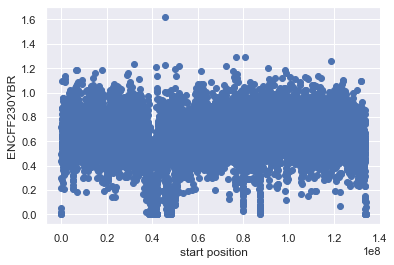

In [5]:
plt.scatter(df.start, df.ENCFF230YBR) 
plt.xlabel('start position')
plt.ylabel('ENCFF230YBR')

# prominent dip at around 0.4

Text(0, 0.5, 'ENCFF953CVO')

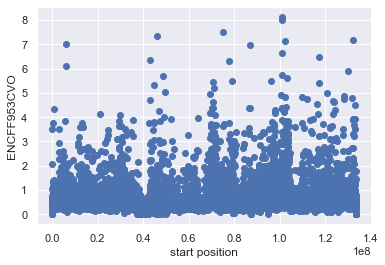

In [6]:
plt.scatter(df.start, df.ENCFF953CVO) 
plt.xlabel('start position')
plt.ylabel('ENCFF953CVO')

Text(0, 0.5, 'ENCFF520IHF')

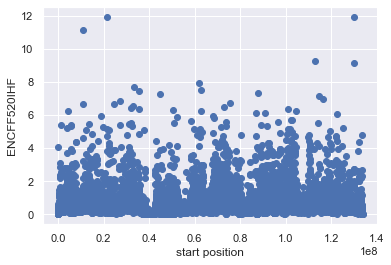

In [7]:
plt.scatter(df.start, df.ENCFF520IHF) 
plt.xlabel('start position')
plt.ylabel('ENCFF520IHF')

Text(0, 0.5, 'ENCFF520IHF')

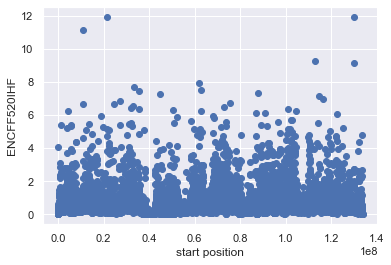

In [8]:
plt.scatter(df.start, df.ENCFF520IHF) 
plt.xlabel('start position')
plt.ylabel('ENCFF520IHF')

#### Q1 Answer: 
In each of these plots we can see a dip at around 40Mb. This could be an indicator that the centromer is located at approximately 40Mb. After looking this up (https://en.wikipedia.org/wiki/Chromosome_10), we see that the centromere's position in chromosome 10 is indeed at 39.8 Mbp, explaining the dip in signal.

**2. Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.**


In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x=df.iloc[:,3:]
pca.fit(x)

PCA(n_components=2)

In [10]:
X_pca = pca.transform(x)

In [11]:
projected = pca.fit_transform(x)
print(projected.shape)

(13380, 2)


In [12]:
projected

array([[-6.42601071,  2.35383448],
       [-5.79046691,  0.96736623],
       [-6.39276725,  2.31721034],
       ...,
       [-6.37280604,  2.29270984],
       [-5.90305078,  1.69625283],
       [-6.42742404,  2.35377598]])

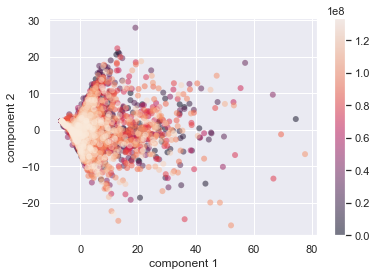

In [13]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=df.start, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

**3. Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.**

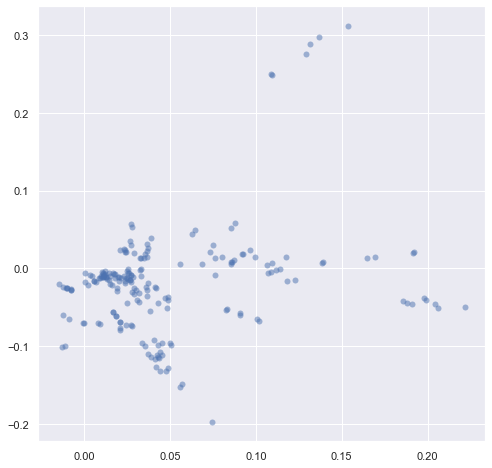

In [14]:
plot_pca(pca,bigwig_metadata=bigwig_metadata)

In [15]:
# Column names for reference
bigwig_metadata.columns

Index(['Unnamed: 0', 'File accession', 'File format', 'File type',
       'File format type', 'Output type', 'File assembly',
       'Experiment accession', 'Assay', 'Donor(s)', 'Biosample term id',
       'Biosample term name', 'Biosample type', 'Biosample organism',
       'Biosample treatments', 'Biosample treatments amount',
       'Biosample treatments duration',
       'Biosample genetic modifications methods',
       'Biosample genetic modifications categories',
       'Biosample genetic modifications targets',
       'Biosample genetic modifications gene targets',
       'Biosample genetic modifications site coordinates',
       'Biosample genetic modifications zygosity', 'Experiment target',
       'Library made from', 'Library depleted in', 'Library extraction method',
       'Library lysis method', 'Library crosslinking method',
       'Library strand specific', 'Experiment date released', 'Project',
       'RBNS protein concentration', 'Library fragmentation method',
      

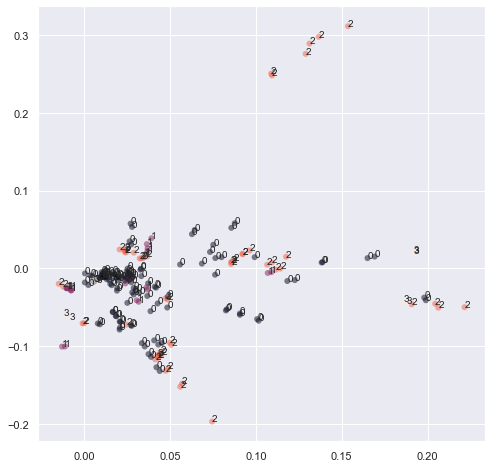

In [16]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Biosample type")

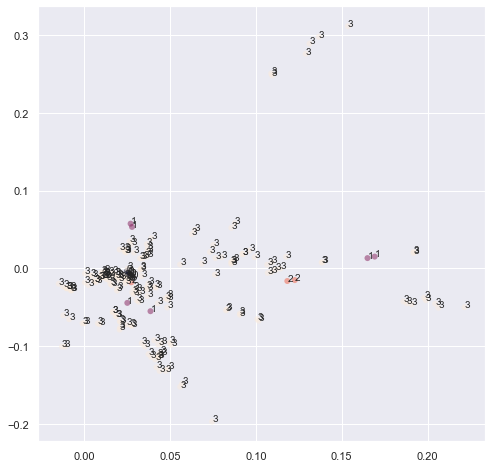

In [17]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Biosample treatments")

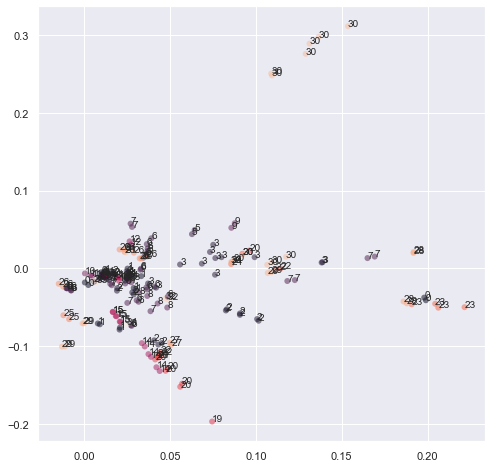

In [18]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Donor(s)")

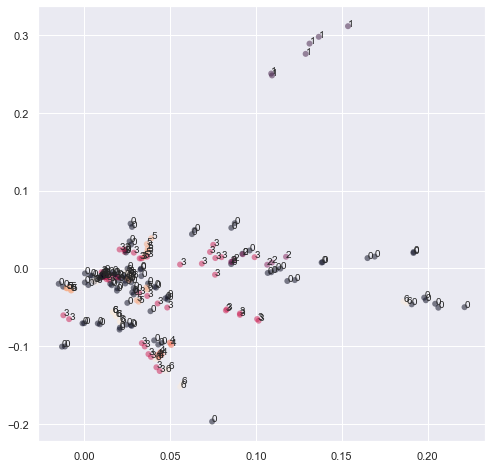

In [19]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Audit ERROR")

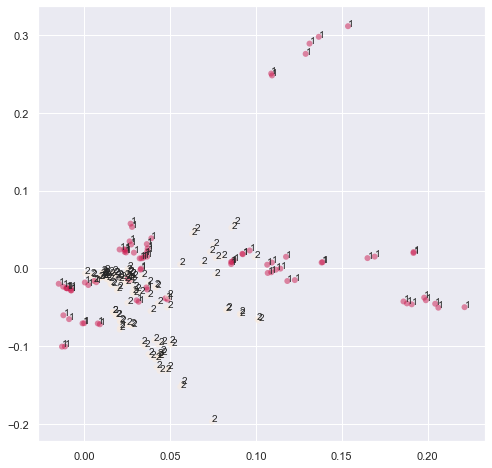

In [20]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Assay")

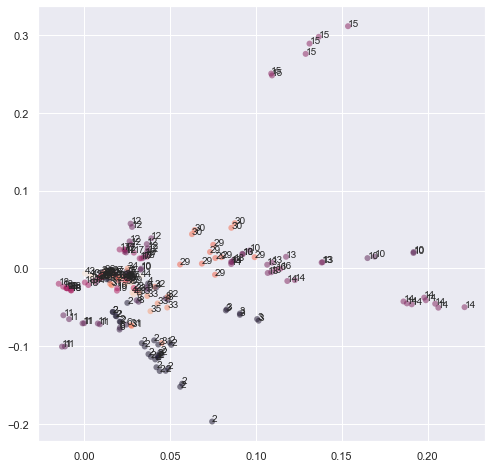

In [21]:
plot_pca(pca,bigwig_metadata=bigwig_metadata,metadata_label_column="Experiment target")

In [22]:
def plot_pca( pca , 
             bigwig_metadata=None,
             metadata_label_column=None, 
             alpha=0.5, 
             lw=0, 
             figsize=(8,8)):
    
    """ 
    Skeleton for plotting PCA and annotating the plot. 
    Can be modified/extended to answer various questions.
    """
    
    
    if metadata_label_column is not None:
        if bigwig_metadata is None: 
            raise ValueError("must provide metadata table to label by a metadata column") 
        labels = [bigwig_metadata.query(
                    "`File accession`==@ file_accession ").loc[:,metadata_label_column].values[0]
                  for file_accession in pca.feature_names_in_]
        le = sklearn.preprocessing.LabelEncoder()
        le.fit(labels)
        labels = le.transform(labels)
    else: 
        labels = None
        
    plt.figure(figsize=figsize)
    plt.scatter(pca.components_[0],
                pca.components_[1],
                c = labels,
                alpha=alpha,
                lw=lw
               )
    
    for i, txt in enumerate(labels):
        plt.annotate(txt, (pca.components_[0][i], pca.components_[1][i]))

**4. Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.**


In [23]:
bigwig_metadata.loc[:,"Assay"]
bigwig_metadata["Assay"].nunique()

30

In [24]:
#from statsmodels.graphics.tsaplots import plot_acf
#plot_acf(bigwig_metadata["Assay"])
#pd.plotting.lag_plot(bigwig_metadata["Assay"], lag=1)

In [25]:
import statsmodels.api as sm

#calculate autocorrelations
sm.tsa.acf(bigwig_metadata["Assay"])

ValueError: could not convert string to float: 'TF ChIP-seq'

**5. Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.**


**6. How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing.**


**7. How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot).**


**8. How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.**


**9. Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).**
